In [7]:
from ProjectRoot import change_wd_to_project_root 
change_wd_to_project_root()
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from src.utils.notebook_imports import *
Console_and_file_logger('model_layer_output')

gpu_id = '1'
current_gpu = choose_gpu_by_id(gpu_id)

from src.models.ModelManager import load_pretrained_model
from sklearn.model_selection import train_test_split

import tensorflow.keras
from keras.models import Model
import src.utils.my_metrics as metr
from skimage.transform import resize
from src.models.ModelManager import create_2d_unet
from src.data.generators import DataGenerator
from src.data.dataset import get_img_msk_files_from_split_dir
from src.visualization.visualize import show_slice_transparent, show_slice, show_2D_or_3D

2019-09-12 15:43:31,260 INFO -------------------- Start --------------------
2019-09-12 15:43:31,261 INFO Working directory: /mnt/data/git/cardio.
2019-09-12 15:43:31,261 INFO Log file: ./logs/model_layer_output.log


search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3061950334555056163
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14039814209509739461
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23871111168
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1054375268840051514
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:02:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12995834942125272154
physical_device_desc: "device: XLA_GPU device"
]


# Create a custom 2d unet

In [3]:
model = create_2d_unet({} )

2019-09-06 10:20:17,784 INFO Optimizer: Adam


# Load a pretrained model

In [58]:
# load a pretrained model
@interact
def interact_load_pretrained_model(config_file=sorted(glob.glob('reports/configs/2D/close_gap/**/**/*.json',)), load=False):
    """
    load past config for model training 
    """
    metrics = [
    metr.bce_dice_jac_loss,
    metr.dice_coef,
    metr.dice_coef_labels,
    metr.dice_coef_background,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv]
    LOSS_FUNCTION = keras.losses.categorical_crossentropy
    # load config with all params into global namespace
    if load:
        with open(config_file, encoding='utf-8') as data_file:
            config = json.loads(data_file.read())
        #globals()['MODEL_PATH'] = config['MODEL_PATH']
        logging.info('Experiment: {}'.format(config['EXPERIMENT']))
        logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
        config['LOSS_FUNCTION'] =  LOSS_FUNCTION
        try:
            # load model
            globals()['model'] = load_pretrained_model(config, metrics)
            globals()['config'] = config
            model.summary()
        except Exception as e:
            logging.error(str(e))

interactive(children=(Dropdown(description='config_file', options=('reports/configs/2D/close_gap/acdc_plus0/20…

# Visualise Layer names

In [7]:
for layer in model.layers:
    print(layer.name)

input_1
conv2d_1
batch_normalization_1
dropout_1
conv2d_2
batch_normalization_2
max_pooling2d_1
conv2d_3
batch_normalization_3
dropout_2
conv2d_4
batch_normalization_4
max_pooling2d_2
conv2d_5
batch_normalization_5
dropout_3
conv2d_6
batch_normalization_6
max_pooling2d_3
conv2d_7
batch_normalization_7
dropout_4
conv2d_8
batch_normalization_8
max_pooling2d_4
conv2d_9
batch_normalization_9
dropout_5
conv2d_10
batch_normalization_10
conv2d_transpose_1
concatenate_1
conv2d_11
batch_normalization_11
dropout_6
conv2d_12
batch_normalization_12
conv2d_transpose_2
concatenate_2
conv2d_13
batch_normalization_13
dropout_7
conv2d_14
batch_normalization_14
conv2d_transpose_3
concatenate_3
conv2d_15
batch_normalization_15
dropout_8
conv2d_16
batch_normalization_16
conv2d_transpose_4
concatenate_4
conv2d_17
batch_normalization_17
dropout_9
conv2d_18
batch_normalization_18
conv2d_19


In [59]:
type(model)

keras.engine.training.Model

In [60]:
layer_name = 'conv2d_10'
model.get_layer(layer_name)

In [61]:
model.input.shape

TensorShape([Dimension(None), Dimension(224), Dimension(224), Dimension(1)])

# Build Wrapper-Model to get the output of one intermediate layers

In [62]:


# Build a wrapper model, define new ouptut

intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output)

# Create random noise and predict the output

In [63]:
test = np.random.random((16,*config['DIM'],1)) # create random noise
intermediate_output = intermediate_layer_model.predict(test)

In [64]:
intermediate_output.shape

(16, 14, 14, 256)

In [65]:
# plot random noise prediction
@interact
def plot_intermediate(img= (0,intermediate_output.shape[1]), feature= (0,intermediate_output.shape[-1])):
    
    ncols = 3
    nrows = 1
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 10, nrows * 10))
    
    axes[0].imshow(test[img,:,:,0])
    axes[0].set_title('Input image {}'.format(img))
    axes[1].imshow(intermediate_output[img,:,:,feature])
    axes[1].set_title('Feature map: {}'.format(feature))
    axes[2].imshow(resize(intermediate_output[img,:,:,feature], test[img,:,:,0].shape, anti_aliasing=True))
    axes[2].set_title('Feature map - resized: {}'.format(feature))
    plt.show()

interactive(children=(IntSlider(value=7, description='img', max=14), IntSlider(value=128, description='feature…

# Load ACDC 2D data

In [86]:
# create a batchgenerator
# load a real image
images_f, masks_f = get_img_msk_files_from_split_dir('data/raw/ACDC/2D/val/')
len(images_f)

#avoid augmentation
config['AUGMENT_GRID'] = False
batch_generator = DataGenerator(images_f, masks_f, config)
acdc_test_images = batch_generator.__getitem__(0)[0]


2019-09-06 11:25:40,670 INFO Create DataGenerator
2019-09-06 11:25:40,672 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 24
 Scaler: MinMax
 Images: 434 
 Augment_grid: False
2019-09-06 11:25:40,672 INFO No augmentation


In [87]:
intermediate_output_image = intermediate_layer_model.predict(acdc_test_images)

In [88]:
intermediate_output_image.shape

(24, 14, 14, 256)

# Visualise the feature maps for one batch

In [70]:
@interact
def plot_intermediate(img= (0,intermediate_output_image.shape[1]), feature= (0,intermediate_output_image.shape[-1])):
    
    ncols = 3
    nrows = 1
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 10, nrows * 10))
    
    axes[0].imshow(test_images[img,:,:,0])
    axes[0].set_title('Input image {}'.format(img))
    axes[1].imshow(intermediate_output_image[img,:,:,feature])
    axes[1].set_title('Feature map: {}'.format(feature))
    axes[2].imshow(resize(intermediate_output_image[img,:,:,feature], test_images[img,:,:,0].shape, anti_aliasing=True))
    axes[2].set_title('Feature map - resized: {}'.format(feature))
    plt.show()

interactive(children=(IntSlider(value=7, description='img', max=14), IntSlider(value=128, description='feature…

# Build Model wrapper which outputs all layers

In [89]:
# get all layers
layers = [layer.name for layer in model.layers if 'input' not in layer.name]
outputs = [model.get_layer(layer).output for layer in layers]

# define a wrapper model to get the output of all layers
all_layers_model = Model(inputs=model.input,outputs=outputs)

In [91]:
# predict on test images
all_layers_output = all_layers_model.predict(acdc_test_images)

In [92]:
# predict on original model
pred = model.predict(acdc_test_images)

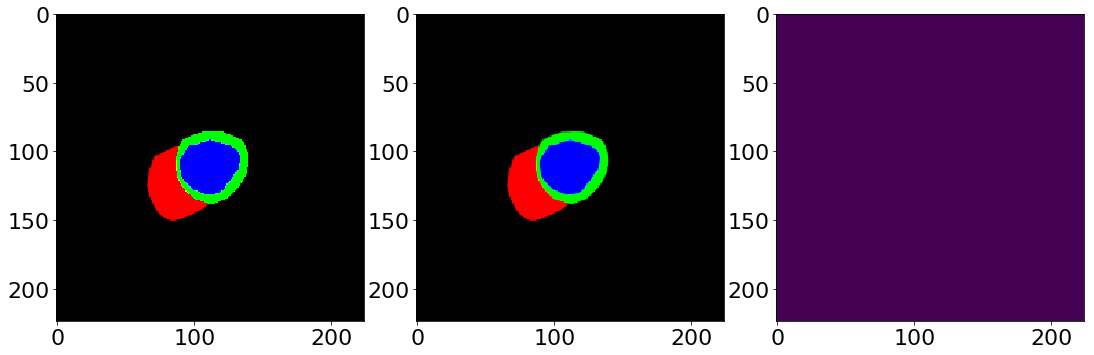

2019-09-06 11:08:56,603 INFO Image-shape: (224, 224)
2019-09-06 11:08:56,604 INFO Image data points: 0
2019-09-06 11:08:56,604 INFO Image mean: 0.000
2019-09-06 11:08:56,605 INFO Image max: 0.000
2019-09-06 11:08:56,605 INFO Image min: 0.000
2019-09-06 11:08:56,606 INFO Mask-shape: (224, 224, 3)
2019-09-06 11:08:56,606 INFO RV mask data points: 50176
2019-09-06 11:08:56,606 INFO Myo mask data points: 50176
2019-09-06 11:08:56,607 INFO LV mask data points: 50176
2019-09-06 11:08:56,607 INFO RV mask mean: 0.02451271377503872
2019-09-06 11:08:56,608 INFO Myo mask mean: 0.018275227397680283
2019-09-06 11:08:56,608 INFO LV mask mean: 0.026808664202690125


In [76]:
test = pred[10]
show_slice(mask=test)

In [77]:
# how many layers exclusive input layer?
len(all_layers_output)

58

In [78]:
# print the first featuremap for each layers of the model for one image
@interact
def show_all_layers_for_one_image(img=(0,test_images.shape[0]), plot=False):
    plt.imshow(test_images[img,:,:,0])
    plt.show()
    if plot:
        #img = 0
        ncols = 10
        nrows = int(len(all_layers_output)/ncols)

        # create a grid
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
        axes = axes.flatten()

        # show input image
        axes[0].imshow(test_images[img,:,:,0])
        axes[0].set_title('Input image {}'.format(img))

        # show ouput image
        axes[1].imshow(show_slice(mask=pred[img,...], show=False))
        axes[1].set_title('output image {}'.format(img))

        # show one image output of all layers
        for layer_name, output, ax in zip(layers, all_layers_output, axes[2:]):
            ax.imshow(output[img,:,:,0])
            ax.set_title('layer: {} \n shape: {}'.format(layer_name, output.shape),fontsize=18, ha='center')
        plt.tight_layout()

interactive(children=(IntSlider(value=12, description='img', max=24), Checkbox(value=False, description='plot'…

# model trained with ACDC - predicted on ACDC val data
## ACDC featuremaps of all layers

In [8]:
# load a pretrained model
@interact
def interact_load_pretrained_model(config_file=sorted(glob.glob('reports/configs/2D/close_gap/**/**/*.json',)), load=False):
    """
    load past config for model training 
    """
    metrics = [
    metr.bce_dice_jac_loss,
    metr.dice_coef,
    metr.dice_coef_labels,
    metr.dice_coef_background,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv]
    LOSS_FUNCTION = keras.losses.categorical_crossentropy
    # load config with all params into global namespace
    if load:
        with open(config_file, encoding='utf-8') as data_file:
            config = json.loads(data_file.read())
        #globals()['MODEL_PATH'] = config['MODEL_PATH']
        logging.info('Experiment: {}'.format(config['EXPERIMENT']))
        logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
        config['LOSS_FUNCTION'] =  LOSS_FUNCTION
        try:
            # load model
            globals()['model'] = load_pretrained_model(config, metrics)
            globals()['config'] = config
            #model.summary()
        except Exception as e:
            logging.error(str(e))

interactive(children=(Dropdown(description='config_file', options=('reports/configs/2D/close_gap/acdc_plus0/20…

In [10]:
# create a batchgenerator
# load a real image
@interact
def load_data(dir='data/raw/ACDC/2D/val/', load=False):
    
    if load:
        images_f, masks_f = get_img_msk_files_from_split_dir('data/raw/ACDC/2D/val/')
        logging.info('loaded: {} files'.format(len(images_f)))

        #avoid augmentation
        config['AUGMENT_GRID'] = False
        batch_generator = DataGenerator(images_f, masks_f, config)
        globals()['test_images'] = batch_generator.__getitem__(0)[0]

        # get all layers
        layers = [layer.name for layer in model.layers if 'input' not in layer.name]
        outputs = [model.get_layer(layer).output for layer in layers]

        # define a wrapper model to get the output of all layers
        globals()['model_all_layers'] = Model(inputs=model.input,outputs=outputs)

interactive(children=(Text(value='data/raw/ACDC/2D/val/', description='dir'), Checkbox(value=False, descriptio…

In [11]:
# get output of all layers for test data
pred_all_layers = model_all_layers.predict(test_images)

# get the output of the original model for the test data
pred = model.predict(test_images)

In [13]:
# print all layers output for one image
@interact
def show_n_featuremaps_per_layer(img=(0,test_images.shape[0]), features_per_layer = (1, 20), plot=False):
    #plt.imshow(test_images[img,:,:,0])
    #plt.show()
    #show_slice(mask=pred[img,...], show=True)
    show_2D_or_3D(test_images[img,:,:,0],  mask=pred[img,...])
    
    if plot:
        #img = 0
        ncols = features_per_layer
        nrows = len(pred_all_layers)

        # create a grid
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
        axes = axes.flatten()

        # show output of all layers
        ax_idx = 0
        
        for layer_name, output in zip(layers, pred_all_layers): # traverse through all layers output tensors
            
            for c in range(features_per_layer): # get 10 examples of each layer if possible
                
                if c < output.shape[-1]: # make sure the current output tensor has enough feature maps
                    
                    try:
                        axes[ax_idx].imshow(output[img,:,:,c])
                        axes[ax_idx].set_title('layer:{}, c:{} \n shape:{}'.format(layer_name, c, output.shape),fontsize=18, ha='center')
                    except Exception as e:
                        print(str(e))
                        
                # increase ax-id to make sure we get a new line for each model layer
                ax_idx += 1
        plt.tight_layout()

interactive(children=(IntSlider(value=12, description='img', max=24), IntSlider(value=10, description='feature…

# Load Fallot data

In [58]:
# load a pretrained model
@interact
def interact_load_pretrained_model(config_file=sorted(glob.glob('reports/configs/2D/close_gap/**/**/*.json',)), load=False):
    """
    load past config for model training 
    """
    metrics = [
    metr.bce_dice_jac_loss,
    metr.dice_coef,
    metr.dice_coef_labels,
    metr.dice_coef_background,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv]
    LOSS_FUNCTION = keras.losses.categorical_crossentropy
    # load config with all params into global namespace
    if load:
        with open(config_file, encoding='utf-8') as data_file:
            config = json.loads(data_file.read())
        #globals()['MODEL_PATH'] = config['MODEL_PATH']
        logging.info('Experiment: {}'.format(config['EXPERIMENT']))
        logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
        config['LOSS_FUNCTION'] =  LOSS_FUNCTION
        try:
            # load model
            globals()['model'] = load_pretrained_model(config, metrics)
            globals()['config'] = config
            model.summary()
        except Exception as e:
            logging.error(str(e))

interactive(children=(Dropdown(description='config_file', options=('reports/configs/2D/close_gap/acdc_plus0/20…

In [103]:
# create a batchgenerator
# load a real image
images_f, masks_f = get_img_msk_files_from_split_dir('data/raw/tetra/2D/val/')

#avoid augmentation
config['AUGMENT_GRID'] = False
config['SHUFFLE'] = False
batch_generator = DataGenerator(images_f, masks_f, config)
test_images_fallot = batch_generator.__getitem__(0)[0]

2019-09-06 11:39:10,274 INFO Create DataGenerator
2019-09-06 11:39:10,279 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 24
 Scaler: MinMax
 Images: 1870 
 Augment_grid: False
2019-09-06 11:39:10,280 INFO No augmentation


In [104]:
# predict on test images
all_layers_output_fallot = all_layers_model.predict(test_images_fallot)

# predict on original model
pred_fallot = model.predict(test_images_fallot)

In [105]:
# print all layers output for one image
@interact
def show_n_featuremaps_per_layer(img=(0,test_images_fallot.shape[0]), features_per_layer = (1, 20), plot=False):
    plt.imshow(test_images_fallot[img,:,:,0])
    plt.show()
    show_slice(mask=pred_fallot[img,...], show=True)
    show_2D_or_3D(test_images_fallot[img,:,:,0],  mask=pred_fallot[img,...])
    
    if plot:
        # define grid, one row per layer and n images/featuremaps each
        ncols = features_per_layer
        nrows = len(all_layers_output_fallot)
        size_per_featuremap = 5

        # create a grid, make the gridsize dynamic
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * size_per_featuremap, nrows * size_per_featuremap))
        axes = axes.flatten() # flatten grid of axes to make linear indexing possible

        # show n feature maps per layer
        ax_idx = 0
        
        for layer_name, output in zip(layers, all_layers_output_fallot): # traverse through all layers output tensors
            
            for c in range(features_per_layer): # get 10 examples of each layer if possible
                
                if c < output.shape[-1]: # make sure the current output tensor has enough feature maps
                    
                    try:
                        axes[ax_idx].imshow(output[img,:,:,c])
                        axes[ax_idx].set_title('layer:{}, c:{} \n shape:{}'.format(layer_name, c, output.shape),fontsize=18, ha='center')
                    except Exception as e:
                        print(str(e))
                        
                # increase ax-id to make sure we get a new line for each model layer
                ax_idx += 1
        plt.tight_layout()

interactive(children=(IntSlider(value=12, description='img', max=24), IntSlider(value=10, description='feature…